# Deep Q-Network implementation (TensorFlow).

In this notebook, we will implement DQN with **experience replay** and **target networks**. Previous notebook had code in PyTorch and this notebook will replicate most of the same code using Tensorflow library.

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use $\epsilon$-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update.

In case of function approximation using neural network, the input to the network is the state and output is the $q(s,a)$ for all the actions in the state $s$. It is denoted as $ \hat{q}(s_t, a_t; w_{t}) $, where $w_{t}$ is the weigths of the neural network that we learn as part of DQN learning.

We use two networks, one target network with weight $w^-_t$ to get the max $q$-value of next state with best action denoted by $ \max\limits_a \hat {q}(S_{t+1},a; w^{-}_{t}) $ and network with weights $w_t^-$ which we periodically updated from primary network $w_t$.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a;w^{-}_{t}) – \hat{q}(S_t,A_t;w_t)] \nabla \hat{q}_{w_t}(S_t,A_t;w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values.

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions `(current state, action, reward, next state)` in a buffer, where each sample is denoted as a tuple:

$$ (s_{i}, a_{i}, r_{i}, s'_{i}, done_{i})$$

Subscript ($i$) denotes ith sample. We take $N$ samples from experience replay selecting randomly and update the weights. Subscript ($t$) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_{i},a';w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter6


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /kaggle/working/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter6

In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

### Imports

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode

from IPython.display import HTML

%matplotlib inline

2023-11-05 06:01:59.205661: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 06:01:59.259383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 06:01:59.259426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 06:01:59.259447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 06:01:59.268089: I tensorflow/core/platform/cpu_feature_g

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole. In another notebook we will run this on other environments like Atari games and a few others.

In [2]:
def make_env(env_name):
    # increase time limit from 200/500 to 4000
    env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=4000)
    return env

state shape:(4,)
Number of Actions:2


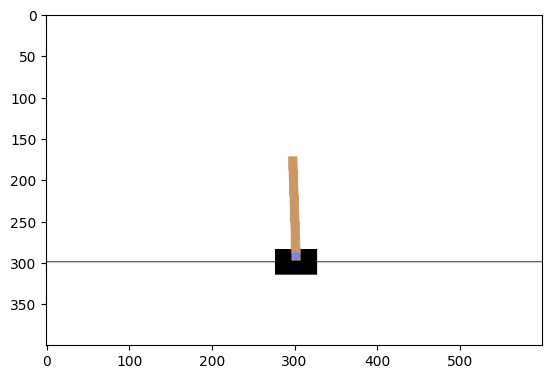

In [9]:
env_name = 'CartPole-v1'
seed=123

env = make_env(env_name)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

### Building a network using tensorflow

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions. 

In [4]:
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(state_dim,)))
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dense(n_actions))
    
    def __call__(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.model(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        qvalues = self.model(states)
        return qvalues.numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [5]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5)

In [6]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 67586 (264.01 KB)
Trainable params: 67586 (264.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(np.array([s]))
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [10]:
print(evaluate(env, agent, n_games=1))
env.close()

16.0


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon$-greedy) to sample from the environment and store the transitions `(s,a,r,s',done)` into a buffer. These samples are used multiple times in a learning making the process sample efficient.

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [11]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [31]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(np.array([s]))
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, terminated, truncated, _ = env.step(a)
        sum_rewards += r
        done = terminated or truncated
        exp_replay.add(s, a, r, next_s, done)
        if terminated:
            s, _ = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [13]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5)
target_network.model.set_weights(agent.model.get_weights())

### Learning with DQN
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation:

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}_{w_t}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_{w_t} L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}_{w_t}(s_i,a_i;w_t)$$


$\hat{q}(s',a';w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network.

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max\limits_{a'} \hat{q}(s'_i,a';w^-_t)$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$
w_{t+1} \leftarrow w_t - \alpha . \nabla_{w_t}L$$

In [14]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99):

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    row_indices= tf.range(len(actions))
    indices = tf.transpose([row_indices, actions])
    predicted_qvalues_for_actions = tf.gather_nd(predicted_qvalues, indices)
    

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

    # compute "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = tf.keras.losses.MSE(target_qvalues_for_actions, predicted_qvalues_for_actions)

    return loss

### Main loop

We now carryout the training on DQN setup above.

In [15]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [16]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### Set up Environment and Policy

In [22]:
#setup env and agent and target networks
env_name = 'CartPole-v1'
env = make_env(env_name)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset(seed=seed)

agent = DQNAgent(state_dim, n_actions, epsilon=1)
target_network = DQNAgent(state_dim, n_actions, epsilon=1)
target_network.model.set_weights(agent.model.get_weights())

#### Populate Experience Replay

In [32]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


#### Setup Training Parameters

In [33]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**4

#init Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [34]:
mean_rw_history = []
td_loss_history = []

In [35]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.05000


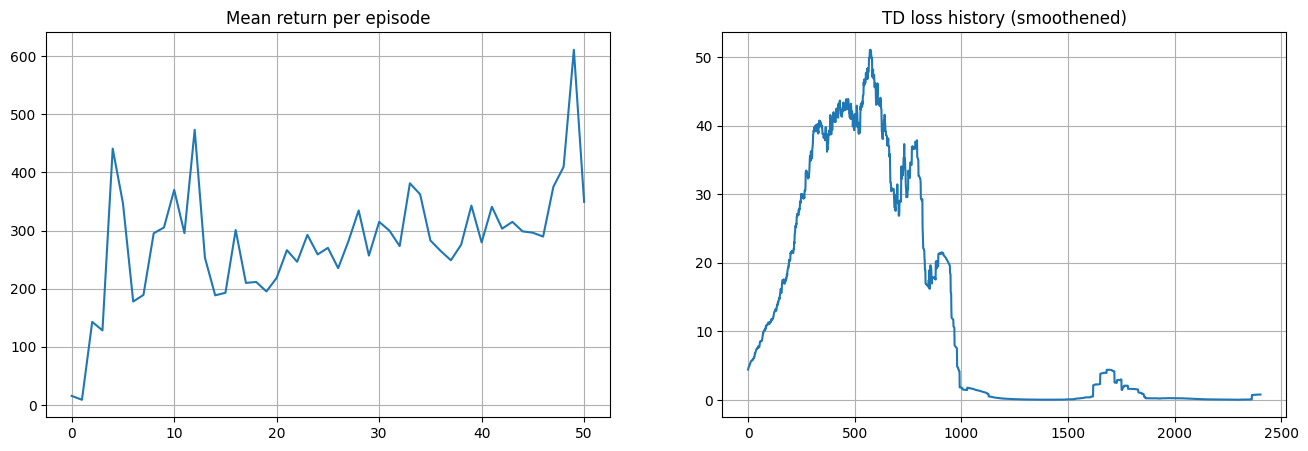

100%|█████████████████████████████████████████████████████████████████████████████| 50001/50001 [24:29<00:00, 34.04it/s]


In [37]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    
    with tf.GradientTape() as tape:
        # loss = <compute TD loss>
        loss = compute_td_loss(agent, target_network, 
                               states, actions, rewards, next_states, done_flags,                  
                               gamma=0.99)

    gradients = tape.gradient(loss, agent.model.trainable_variables)
    clipped_grads = [tf.clip_by_norm(g, max_grad_norm) for g in gradients]
    optimizer.apply_gradients(zip(clipped_grads, agent.model.trainable_variables))


    if step % loss_freq == 0:
        td_loss_history.append(loss.numpy())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.model.set_weights(agent.model.get_weights())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean return per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [38]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 332.4
Well done


#### Record and Play a video of trained agent

In [43]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = np.argmax(agent.get_qvalues(obs),axis=-1)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

In [44]:
video_folder = "logs/6_a/vanilla/videos/tf/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_a/vanilla/videos/tf/DQNAgent-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_a/vanilla/videos/tf/DQNAgent-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_a/vanilla/videos/tf/DQNAgent-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_a/vanilla/videos/tf/DQNAgent-CartPole-v1-step-0-to-step-500.mp4


#### Important Notes

We cannot use stablebaseline3 (SB3) or SB#-Zoo with Tensorflow as SB3 and SB3-Zoo work only with PyTorch. In order to use it alongwith Tensorflow you can either switch to older version of Stablebaselines i.e. [stablebaselines2(SB2)](https://stable-baselines.readthedocs.io/en/master/guide/install.html). However the older version has two issues, it does not work with the newer Gymnasium library and it still depends on the older Gym library. In addition, SB2 works with older versions of Tensorflow only. 

There is another option, that of using [Tensorflow Agents](https://www.tensorflow.org/agents). This again works with the older gym library and does not have support from Gymnasium.

My advice for the learner would be to stick to PyTorch ecosystem while learning. As and when you work on a RL project which specifically needs TensorFlow backend, you could look at the above options. In any case, you would have your own environment which can be implemented on top of the Gym interface. In that case you do not need to bother about the newer Gymnasium interface.

### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks. We can improve this agent with many tricks. As we go along, we will be implementing many of these variants.